In [59]:
import os, json
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
total_data = []
filepath = '/home/paperspace/siliang/llama-recpies/eval/infer_log/llama_13bf_full_valid_0410.json'
# filepath = '/home/paperspace/siliang/llama-recpies/eval/infer_log/llama_13bf_full_valid_0410_valid.json'
with open(filepath) as f:
    for line in f:
        dic = json.loads(line)
        for d in dic['details']:
            d['prob'] = np.exp(d.pop('logprob'))
        total_data.append(dic)
print(len(total_data))

2700


In [61]:
total_data[0]
keys = ['id', 'idx', 'input_str', 'response', 'model', 'task_type', 'labels', 'output', 'details']
save_data = []
for dic in total_data:
    new_dic = {}
    for k in keys:
        new_dic[k] = dic[k]
    save_data.append(new_dic)
df = pd.DataFrame(save_data)
# df.to_csv('../infer_res/llama2_13b_lora_0217_merge.csv')
print(df.shape)

(2700, 9)


# 计算一下假阳/真阳性前两个token的概率密度

In [62]:
fp_dic = {'first': [], 'second': []}
tp_dic = {'first': [], 'second': []}
tn_dic = {'first': [], 'second': []}
fn_dic = {'first': [], 'second': []}
bad_cnt = 0
tp, fp, tn, fn = 0, 0, 0, 0
for dic in total_data:
    try:
        output = literal_eval(dic['output'])
        if not isinstance(output, list):
            bad_cnt += 1
            output = []
    except:
        bad_cnt += 1
        output = []
    labels = dic['labels']
    details = dic['details']
    first_token_prob = details[0]['prob']
    second_token_prob = details[1]['prob']
    if len(output) >0 and len(labels) == 0:
        fp_dic['first'].append(first_token_prob)
        fp_dic['second'].append(second_token_prob)
        fp += 1
    elif len(output) > 0 and len(labels) > 0:
        tp_dic['first'].append(first_token_prob)
        tp_dic['second'].append(second_token_prob)
        tp += 1
    elif len(output) == 0 and len(labels) == 0:
        tn_dic['first'].append(first_token_prob)
        tn_dic['second'].append(second_token_prob)
        tn += 1
    else:
        fn_dic['first'].append(first_token_prob)
        fn_dic['second'].append(second_token_prob)
        fn += 1
print('tp: {}, fp: {}, fn: {}, tn: {}'.format(tp, fp, fn, tn))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(recall+precision)
print('precision: {:.3f}, recall: {:.3f}, f1: {:.3f}'.format(precision, recall, f1))  
print(bad_cnt)

tp: 806, fp: 311, fn: 137, tn: 1446
precision: 0.722, recall: 0.855, f1: 0.783
81


In [63]:
# 根据第一个token改变概率
p_thrds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]
n_thrds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10]

p_thrds = [8]
n_thrds = [0]
best_f1 = 0
for i in p_thrds:
    for j in n_thrds:
        p_thrd = np.percentile(fp_dic['first']+tp_dic['first'], i)
        n_thrd = np.percentile(tn_dic['first']+fn_dic['first'], j)

        fp_dic = {'first': [], 'second': []}
        tp_dic = {'first': [], 'second': []}
        tp, fp, tn, fn = 0, 0, 0, 0
        for dic in total_data:
            try:
                output = literal_eval(dic['output'])
                if not isinstance(output, list):
                    bad_cnt += 1
                    output = []
            except:
                bad_cnt += 1
                output = []
            labels = dic['labels']
            details = dic['details']
            first_token_prob = details[0]['prob']
            second_token_prob = details[1]['prob']
            if len(output) > 0:
                if first_token_prob < p_thrd:
                    output = []
            else:
                if first_token_prob < n_thrd:
                    output = [1]
            if len(output) >0 and len(labels) == 0:
                fp_dic['first'].append(first_token_prob)
                fp_dic['second'].append(second_token_prob)
                fp += 1
            elif len(output) > 0 and len(labels) > 0:
                tp_dic['first'].append(first_token_prob)
                tp_dic['second'].append(second_token_prob)
                tp += 1
            elif len(output) == 0 and len(labels) == 0:
                tn_dic['first'].append(first_token_prob)
                tn_dic['second'].append(second_token_prob)
                tn += 1
            else:
                fn_dic['first'].append(first_token_prob)
                fn_dic['second'].append(second_token_prob)
                fn += 1
        # print('tp: {}, fp: {}, fn: {}, tn: {}'.format(tp, fp, fn, tn))
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2*precision*recall/(recall+precision)
        if f1 > best_f1:
            best_f1 = f1
            print('p_threshold: {:.3f}, n_threshold: {:.3f}'.format(i, j))
            print('precision: {:.3f}, recall: {:.3f}, f1: {:.3f}'.format(precision, recall, f1))

p_threshold: 8.000, n_threshold: 0.000
precision: 0.761, recall: 0.829, f1: 0.794


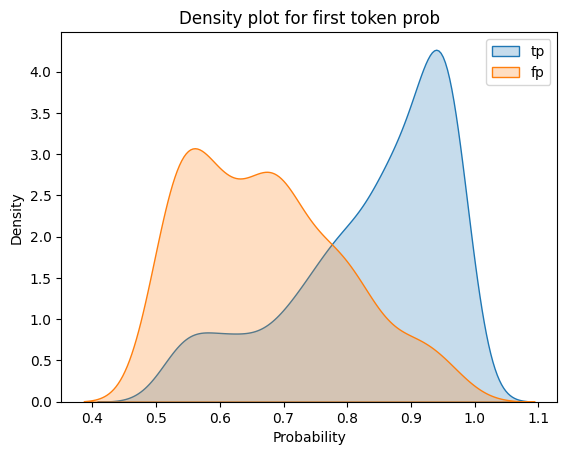

In [64]:
sns.kdeplot(tp_dic['first'], fill=True, label='tp')
sns.kdeplot(fp_dic['first'], fill=True, label='fp')

plt.title('Density plot for first token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

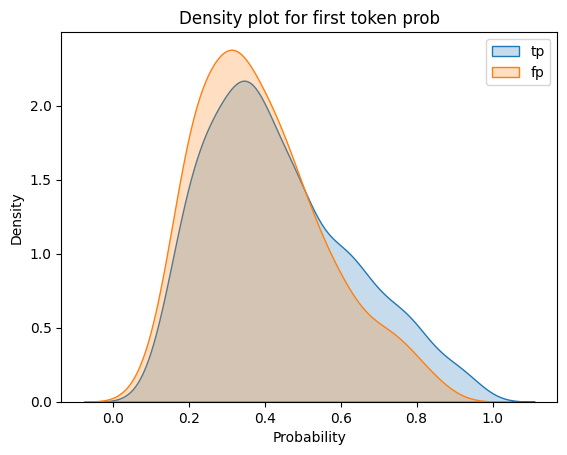

In [65]:
sns.kdeplot(tp_dic['second'], fill=True, label='tp')
sns.kdeplot(fp_dic['second'], fill=True, label='fp')

plt.title('Density plot for first token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

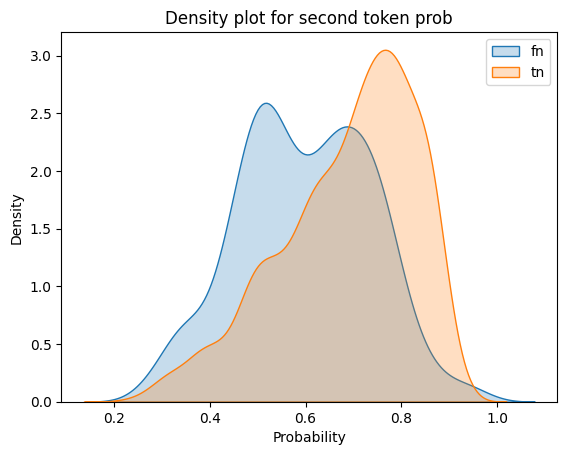

In [66]:
sns.kdeplot(fn_dic['first'], fill=True, label='fn')
sns.kdeplot(tn_dic['first'], fill=True, label='tn')

plt.title('Density plot for second token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

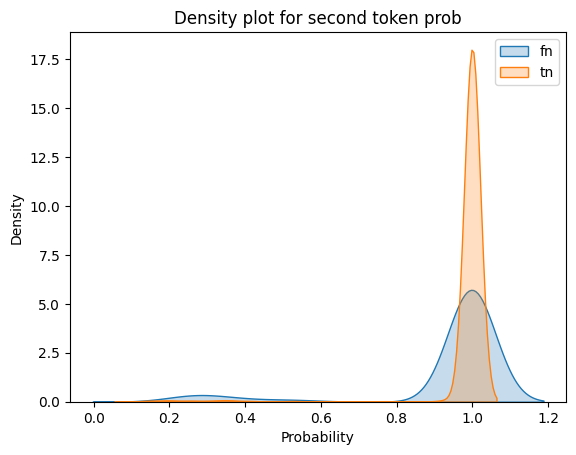

In [67]:
sns.kdeplot(fn_dic['second'], fill=True, label='fn')
sns.kdeplot(tn_dic['second'], fill=True, label='tn')

plt.title('Density plot for second token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()